In [1]:
%load_ext autoreload
%autoreload 2

In [24]:
# import numpy as np
import autograd.numpy as np
from autograd import grad 
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, mark_inset
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import scipy.io
from scipy.special import gamma

from surrogate_models.data_generation import plot_surface_xyz, gen_ac_dc_test_data

plt.style.use('default')
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['mathtext.fontset'] = 'dejavuserif'

In [3]:
def loss_cal_ac_dc(P=-100e3,
                   Q=0,
                   S=500e3,
                   k_Diode=0.5855,
                   k_Eoff=0.7401,
                   k_Eon=1.107,
                   h_Diode=0.0009487,
                   h_Eoff=0.001283,
                   h_Eon=4.023e-05,
                   w=100 * np.pi,
                   Vdc=700,
                   vgll_rms=400,
                   Vce_rated=600,
                   mode=3):
    if mode == 1:
        return 0
    if mode == 2:
        x = P / 1000 / Vdc
        P_loss = 3.311 * x ** 2 + 31.63 * x + 0.3038
        P_loss = P_loss * 1e3
        return P_loss
    
    vgph_rms = vgll_rms / np.sqrt(3)
    vgd = np.sqrt(2) * vgph_rms
    id_ = P / (1.5 * vgd)
    iq = Q / (1.5 * vgd)
    iph_pk = np.sqrt(id_ ** 2 + iq ** 2)
    phi = np.arctan2(Q, P)

    Zbase = vgll_rms ** 2 / S
    Lbase = Zbase / w
    L = 0.1 * Lbase
    R = 1e-2
    vcd = vgd + R * id_ - w * L * iq
    vcq = R * iq + w * L * id_
    vcph_pk = np.sqrt(vcd ** 2 + vcq ** 2)
    m_index = vcph_pk / (0.5 * Vdc)
    delta = np.arctan2(vcq, vcd)
    theta = delta - phi
    pf = np.cos(theta)

    Ve_IGBT = 0.8
    Ve_Diode = 1.147
    Re_IGBT = 1 / 1007
    Re_Diode = 1 / 1374
    fs = 5e3

    Psw_on = ((1 / 2 / np.sqrt(np.pi)) * fs * h_Eon * (iph_pk ** k_Eon) *
              gamma((k_Eon + 1) / 2) / gamma(k_Eon / 2 + 1) * Vdc / Vce_rated)

    Psw_off = (1 / 2 / np.sqrt(np.pi) * fs * h_Eoff * (iph_pk ** k_Eoff) *
               gamma((k_Eoff + 1) / 2) / gamma(k_Eoff / 2 + 1) * Vdc / Vce_rated)

    Prr = (1 / 2 / np.sqrt(np.pi) * fs * h_Diode * (iph_pk ** k_Diode) *
           gamma((k_Diode + 1) / 2) / gamma(k_Diode / 2 + 1) * Vdc / Vce_rated)

    Pcsw = (iph_pk * Ve_IGBT * (1 / (2 * np.pi) + m_index * pf / 8) +
            iph_pk ** 2 * Re_IGBT * (1 / 8 + m_index * pf / (3 * np.pi)))

    PcD = (iph_pk * Ve_Diode * (1 / (2 * np.pi) - m_index * pf / 8) +
           iph_pk ** 2 * Re_Diode * (1 / 8 - m_index * pf / (3 * np.pi)))

    P_loss = (Pcsw + PcD + Psw_on + Psw_off + Prr) * 6 + P * 0.01

    Pcsw = Pcsw * 6
    PcD = PcD * 6
    Psw_on = Psw_on * 6
    Psw_off = Psw_off * 6
    Prr = Prr * 6

    P_loss = np.where(P == 0, 0, P_loss)
#     return P_loss, Psw_on, Psw_off, Prr, Pcsw, PcD
    return P_loss

def f(v, p):
    ploss = loss_cal_ac_dc(p, p * np.arccos(PF), S, k_Diode,
                           k_Eoff, k_Eon, h_Diode, h_Eoff, h_Eon,
                           w, v, vgll_rms, Vce_rated)
    return ploss

def get_grads(vs, ps, func):
    grads = []
    for v, p in np.c_[vs, ps]:
        grads.append(func(v, p))
    return grads

In [21]:
def dummy_plot(ax):
    x = np.linspace(0, 1, 100)
    y = np.random.randint(10) * np.sin(x * 2 * np.pi) + np.random.randint(10)
    ax.plot(x, y)
    y = np.random.randint(10) * np.sin(x * 2 * np.pi) + np.random.randint(10)
    ax.plot(x, y)
    ax.set_xlim(0, 1)
    
def plot_ploss_p(ax, ps, vs, ploss):
    for i in range(len(ps)):
        ax.plot(ps[i], ploss[i], label='$V^{DC}$' + f' = {vs[i]} V')
    ax.set_xlabel('$p_c$ (kW)')
    ax.set_ylabel('$P_{L,c}$ (kW)')
    ax.grid(color='lightgrey', linestyle='--', linewidth=0.5)
    ax.set_xlim(0, 500)
    ax.set_ylim(0, 20)

    axins = zoomed_inset_axes(ax, 8, loc=2)
    for i in range(0, 78, 20):
        axins.plot(ms_p.T[i] / baseMVA, PLOSS.T[i] / baseMVA)
    axins.set_xlim(0, 20)
    axins.set_ylim(0, 1)
    mark_inset(ax, axins, loc1=2, loc2=4, fc="none", ec="0.5")

    axins.set_xticks([])
    axins.set_yticks([])
    
def plot_grad_p(ax, ps, vs, ploss):
    for i in range(len(ps)):
        ax.plot(ps[i], grad_ps[i], label='$V^{DC}$' + f' = {vs[i]} V')
    ax.set_xlabel('$p_c$ (kW)')
    ax.set_ylabel('$\\frac{\\partial p_{L, c}}{\\partial p_c}$', fontsize=12)
    ax.grid(color='lightgrey', linestyle='--', linewidth=0.5)
    ax.yaxis.set_label_coords(-.1, .5)
    ax.set_xlim(1, 500)
    ax.set_ylim(0, 0.1)

    axins = zoomed_inset_axes(ax, 2, loc=9)
    for i in range(len(ps)):
        axins.plot(ps[i], grad_ps[i])
    axins.set_xlim(1, 20)
    axins.set_ylim(0.035, 0.06)
    mark_inset(ax, axins, loc1=2, loc2=4, fc="none", ec="0.5")

    axins.set_xticks([])
    axins.set_yticks([])

def plot_p_grads(axs):
    ps = [ms_p.T[i] / baseMVA for i in range(1, 78, 20)]
    vs = [ms_v.T[i][0] for i in range(1, 78, 20)]
    ploss = [PLOSS.T[i] / baseMVA for i in range(1, 78, 20)]
    plot_ploss_p(axs[0], ps, vs, ploss)
    plot_grad_p(axs[1], ps, vs, ploss)
    plot_grad_p2(axs[2], ps, vs, ploss)
    
def plot_ploss_v(ax, ps, vs, ploss):
    for i in range(len(ps)):
        ax.plot(vs[i], ploss[i], label=f'$p$ = {int(ps[i])} kW')
    ax.set_xlabel('$V^{DC}$ (V)')
    ax.set_ylabel('$p_{L, c} (kW)$')
    ax.grid(color='lightgrey', linestyle='--', linewidth=0.5)
    ax.set_xlim(lb[1], ub[1])
    ax.set_ylim(0, 20)
    
def plot_grad_v(ax, ps, vs, ploss):
    for i in range(len(ps)):
        ax.plot(vs[i], grad_vs[i], label=f'$p$ = {int(ps[i])} kW')
    ax.set_xlabel('$V^{DC}$ (V)')
    ax.set_ylabel('$\\frac{\partial p_{L, c}}{\\partial V^{DC}}$', fontsize=12)
    ax.grid(color='lightgrey', linestyle='--', linewidth=0.5)
    ax.set_xlim(lb[1], ub[1])
    ax.set_ylim(0, 10)
    ax.yaxis.set_label_coords(-.08, .5)

def plot_v_grads(axs):
    ps = [ms_p[i][0] / baseMVA for i in range(200, 1001, 200)]
    vs = [ms_v[i] for i in range(200, 1001, 200)]
    ploss = [PLOSS[i] / baseMVA for i in range(200, 1001, 200)]
    plot_ploss_v(axs[0], ps, vs, ploss)
    plot_grad_v(axs[1], ps, vs, ploss)
    plot_grad_v2(axs[2], ps, vs, ploss)

In [5]:
baseMVA = 1e3
vgll_rms = 400
w = 2 * np.pi * 50
h_Eon = 4.023e-05
h_Eoff = 0.001283
h_Diode = 0.0009487
k_Eon = 1.107
k_Eoff = 0.7401
k_Diode = 0.5855
Vce_rated = 700

PF = 0.0
Vdc = 700
S = 500 * baseMVA
lb = np.array([0.0, 0.94 * Vdc])
ub = np.array([S, 1.05 * Vdc])
delta_P = 500.0
delta_V = 1.0
print(ub, lb)

V = np.arange(lb[1], ub[1] + 0.1, delta_V)
P = np.arange(lb[0], ub[0] + 0.1, delta_P)
ms_v, ms_p = np.meshgrid(V, P)
print(ms_v.shape)

[500000.    735.] [  0. 658.]
(1001, 78)


In [6]:
PLOSS = f(ms_v, ms_p)
dy_dv = grad(f, 0)
dy_dp = grad(f, 1)
dy_dv2 = grad(dy_dv, 0)
dy_dp2 = grad(dy_dp, 1)

In [7]:
# ps = [ms_p.T[i] / baseMVA for i in range(1, 78, 20)]
# vs = [ms_v.T[i][0] for i in range(1, 78, 20)]
# ploss = [PLOSS.T[i] / baseMVA for i in range(1, 78, 20)]

grad_ps = [[0] + get_grads(ms_v.T[i][1:], ms_p.T[i][1:], dy_dp) for i in range(1, 78, 20)]
grad_p2s = [[0] + get_grads(ms_v.T[i][1:], ms_p.T[i][1:], dy_dp2) for i in range(1, 78, 20)]

In [8]:
# ps = [ms_p[i][0] / baseMVA for i in range(200, 1001, 200)]
# vs = [ms_v[i] for i in range(200, 1001, 200)]
# ploss = [PLOSS[i] / baseMVA for i in range(200, 1001, 200)]

grad_vs = [get_grads(ms_v[i], ms_p[i], dy_dv) for i in range(200, 1001, 200)]
grad_v2s = [get_grads(ms_v[i], ms_p[i], dy_dv2) for i in range(200, 1001, 200)]

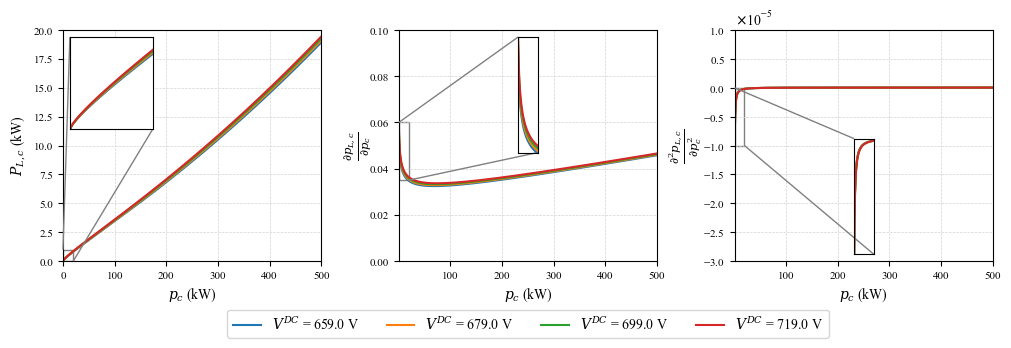

In [26]:
fig, axarr = plt.subplots(1, 3, figsize=(12, 3))
plt.ticklabel_format(axis='y', style='sci', scilimits=(-2, 2), useMathText=True)
plot_p_grads(axarr)
for ax in axarr:
    ax.tick_params(axis='y', labelsize=8)
    ax.tick_params(axis='x', labelsize=8)
axarr[1].legend(loc='upper center', bbox_to_anchor=(0.5, -.18), ncol=4)
fig.subplots_adjust(wspace=0.3)
plt.draw()
plt.savefig('results/graphs/p_grads.pdf', bbox_inches='tight')
plt.show()

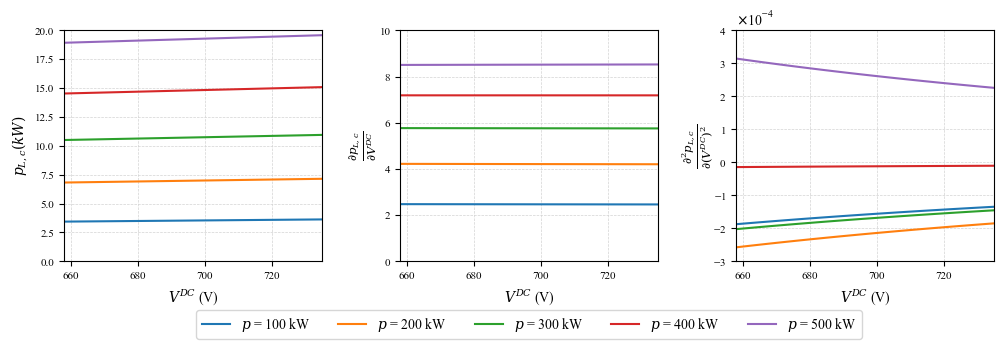

In [25]:
fig, axarr = plt.subplots(1, 3, figsize=(12, 3))
plt.ticklabel_format(axis='y', style='sci', scilimits=(-2, 2), useMathText=True)
plot_v_grads(axarr)
for ax in axarr:
    ax.tick_params(axis='y', labelsize=8)
    ax.tick_params(axis='x', labelsize=8)
axarr[1].legend(loc='upper center', bbox_to_anchor=(0.5, -.18), ncol=5)
fig.subplots_adjust(wspace=0.3)
plt.draw()
plt.savefig('results/graphs/v_grads.pdf', bbox_inches='tight')
plt.show()

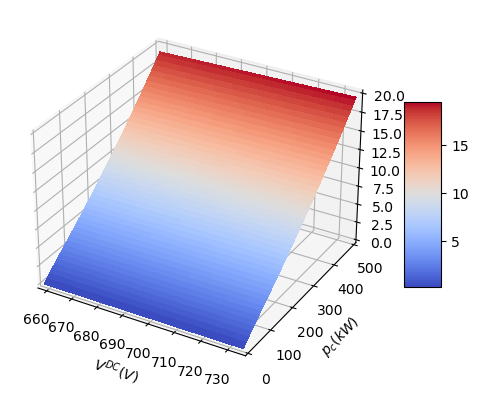

In [236]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ms_x, ms_y = np.meshgrid(V, P)
ms_z = PLOSS.reshape(ms_x.shape)
surf = ax.plot_surface(ms_x, ms_y / baseMVA, ms_z / baseMVA, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
ax.set_zlim(0, 20)
ax.set_xlim(lb[1], ub[1])
ax.set_ylim(lb[0] / baseMVA, ub[0]/ baseMVA)
fig.colorbar(surf, shrink=0.5, aspect=5)
ax.set_xlabel('$V^{DC} (V)$')
ax.set_ylabel('$p_c (kW)$')
ax.set_zlabel('$p_{L, c} (kW)$')
plt.savefig('results/graphs/ploss_pv.pdf')
plt.show()

In [10]:
def calc_loss_p(model, p, v):
    W = model['weights'][0]
    B = [x.flatten() for x in model['biases'][0]]
    ub = model['ub'][0]
    lb = model['lb'][0]
    X = np.c_[p, np.tile(v, p.shape[0])]
    z = (X - lb) / (ub - lb)
    for i in range(len(W)):
        z_hat = (W[i] @ z.T).T + B[i]
        z = np.maximum(z_hat, 0)
    return z.flatten()

def plot_comps_p_all(models, index=0):
    num_plots = len(models)
    p = [ms_p.T[i] / baseMVA for i in range(1, 78, 20)][index]
    v = [ms_v.T[i][0] for i in range(1, 78, 20)][index]
    ploss = [PLOSS.T[i] / baseMVA for i in range(1, 78, 20)][index]
    fig, axarr = plt.subplots(1, num_plots, figsize=(12, 3), sharey=True)
    print(v)
    for i in range(num_plots):
        model = scipy.io.loadmat(models[i])
        u = calc_loss_p(model, p, v)
        plot_comparison_p(axarr[i], p, ploss, u, i==0)
        axarr[i].tick_params(axis='y', labelsize=8)
        axarr[i].tick_params(axis='x', labelsize=8)

    axarr[1].legend(loc='upper center', bbox_to_anchor=(0.5, -.18), ncol=2)
    fig.subplots_adjust(wspace=0.1)
    plt.draw()

def plot_comparison_p(ax, p, ploss, u, label_y):
    ax.plot(p, ploss, label='Exact solution')
    ax.plot(p, u, 'r--', label='Neural network prediction')
    ax.set_xlim(0, 500)
    ax.set_ylim(0, 20)
    
    ax.set_xlabel('$p_c$ (kW)')
    if label_y:
        ax.set_ylabel('$p_{L, c}$ (kW)', fontsize=12)
    ax.grid(color='lightgrey', linestyle='--', linewidth=0.5)
    ax.yaxis.set_label_coords(-.12, .5)

    axins = zoomed_inset_axes(ax, 10, loc=2)
    axins.plot(p, ploss)
    axins.plot(p, u, 'r--')
    axins.set_xlim(0, 20)
    axins.set_ylim(0, 1)
    mark_inset(ax, axins, loc1=2, loc2=4, fc="none", ec="0.5")

    axins.set_xticks([])
    axins.set_yticks([])
    
def calc_loss_v(model, p, v):
    W = model['weights'][0]
    B = [x.flatten() for x in model['biases'][0]]
    ub = model['ub'][0]
    lb = model['lb'][0]
    X = np.c_[np.tile(p, v.shape[0]), v]
    z = (X - lb) / (ub - lb)
    for i in range(len(W)):
        z_hat = (W[i] @ z.T).T + B[i]
        z = np.maximum(z_hat, 0)
    return z.flatten()

def plot_comps_v_all(model, index=0):
    num_plots = len(models)
    p = [ms_p[i][0] / baseMVA for i in range(20, 1001, 200)][index]
    v = [ms_v[i] for i in range(20, 1001, 200)][index]
    ploss = [PLOSS[i] / baseMVA for i in range(20, 1001, 200)][index]
    fig, axarr = plt.subplots(1, 3, figsize=(12, 3), sharey=True)
    print(p)
    for i in range(num_plots):
        model = scipy.io.loadmat(models[i])
        u = calc_loss_v(model, p, v)
        plot_comparison_v(axarr[i], v, ploss, u, i==0)
        axarr[i].tick_params(axis='y', labelsize=8)
        axarr[i].tick_params(axis='x', labelsize=8)
    axarr[1].legend(loc='upper center', bbox_to_anchor=(0.5, -.18), ncol=2)
    fig.subplots_adjust(wspace=0.1)
    plt.draw()

def plot_comparison_v(ax, v, ploss, u, label_y):
    ax.plot(v, ploss, label='Exact solution')
    ax.plot(v, u, 'r--', label='Neural network prediction')
    ax.set_xlim(658, 735)
#     ax.set_ylim(0, 20)
    
    ax.set_xlabel('$V^{DC}$ (V)')
    if label_y:
        ax.set_ylabel('$p_{L, c}$ (kW)', fontsize=12)
    ax.grid(color='lightgrey', linestyle='--', linewidth=0.5)
    ax.yaxis.set_label_coords(-.12, .5)

#     axins = zoomed_inset_axes(ax, 10, loc=2)
#     axins.plot(p, ploss)
#     axins.plot(p, u, 'r--')
#     axins.set_xlim(0, 20)
#     axins.set_ylim(0, 1)
#     mark_inset(ax, axins, loc1=2, loc2=4, fc="none", ec="0.5")

#     axins.set_xticks([])
#     axins.set_yticks([])

In [27]:
models = ['data/base_ac_dc_model', 'data/constrained_ac_dc_model', 'data/ac_dc_relu_model']

659.0


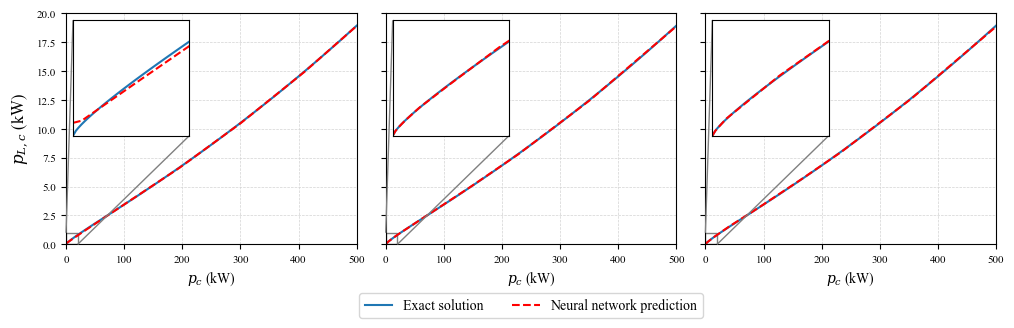

In [28]:
plot_comps_p_all(models)
plt.savefig('results/graphs/p_predictions.pdf', bbox_inches='tight')
plt.show()

10.0


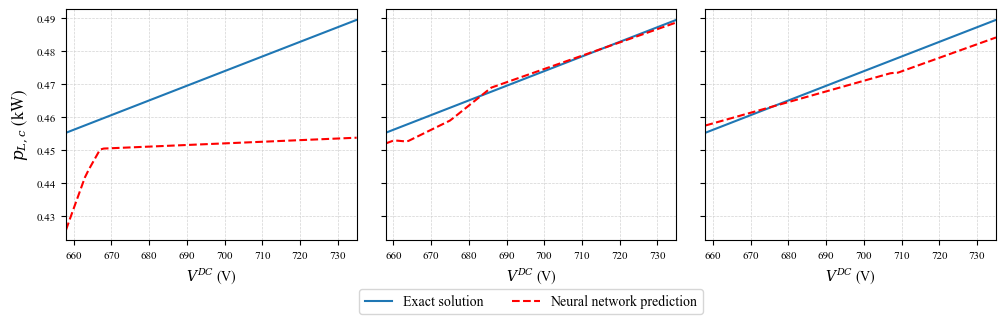

In [29]:
plot_comps_v_all(models)
plt.savefig('results/graphs/v_predictions.pdf', bbox_inches='tight')
plt.show()